In [1]:
import warnings
warnings.filterwarnings("ignore")
import os, cv2, random
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils



Populating the interactive namespace from numpy and matplotlib


In [5]:
path = './'


### Preparing data

# loading labels for each image from csv
labels = pd.read_csv('label.csv')
labels = labels.iloc[:,0:2]
labels.head()



,File Name,Mass
0,22678622,0
1,22678646,1
2,22678670,0
3,22678694,1
4,22614074,1


In [25]:
male_data = labels[labels['Mass '] == 0]
male_data.head()

,File Name,Mass
0,22678622,0
2,22678670,0
8,50997434,0
10,50997488,0
17,22580218,0


In [26]:


# Splitting male data into train and test
test_male_data = male_data.iloc[-3:,:]
train_male_data = male_data.iloc[:-3,:]



In [17]:


# Separating female labels
male_data = labels[labels['Mass '] == 1]
male_data.head()



,File Name,Mass
1,22678646,1
3,22678694,1
4,22614074,1
5,22614097,1
6,22614127,1


In [27]:
# Splitting male data into train and test
test_female_data = female_data.iloc[-3:,:]
train_female_data = female_data.iloc[:-3,:]

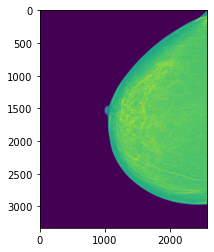

In [61]:
path ='Dataset/'
# Displaying one image to check
img=mpimg.imread(path + '20587294.png')
imgplot = plt.imshow(img)
plt.show()



In [28]:
test_indices = test_female_data.index.tolist() + test_male_data.index.tolist()


In [29]:
test_data = labels.iloc[test_indices,:]
test_data.head()

,File Name,Mass
401,22580098,1
402,22613770,1
404,22613822,1
407,24055752,0
408,24055779,0


In [30]:
# total train data
train_data = pd.concat([labels, test_data, test_data]).drop_duplicates(keep=False)
train_data.head()

,File Name,Mass
0,22678622,0
1,22678646,1
2,22678670,0
3,22678694,1
4,22614074,1


In [154]:
train_image_name = [path + each for each in map(str,train_data['File Name'].values.tolist())]
test_image_name = [path + each for each in map(str,test_data['File Name'].values.tolist())]

In [162]:
ROWS = 64
COLS = 64
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path+'.png', cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%5 == 0: print('Processed {} of {}'.format(i, count))
    
    return data


In [163]:
train = prep_data(train_image_name)
test = prep_data(test_image_name)

Processed 0 of 404
Processed 5 of 404
Processed 10 of 404
Processed 15 of 404
Processed 20 of 404
Processed 25 of 404
Processed 30 of 404
Processed 35 of 404
Processed 40 of 404
Processed 45 of 404
Processed 50 of 404
Processed 55 of 404
Processed 60 of 404
Processed 65 of 404
Processed 70 of 404
Processed 75 of 404
Processed 80 of 404
Processed 85 of 404
Processed 90 of 404
Processed 95 of 404
Processed 100 of 404
Processed 105 of 404
Processed 110 of 404
Processed 115 of 404
Processed 120 of 404
Processed 125 of 404
Processed 130 of 404
Processed 135 of 404
Processed 140 of 404
Processed 145 of 404
Processed 150 of 404
Processed 155 of 404
Processed 160 of 404
Processed 165 of 404
Processed 170 of 404
Processed 175 of 404
Processed 180 of 404
Processed 185 of 404
Processed 190 of 404
Processed 195 of 404
Processed 200 of 404
Processed 205 of 404
Processed 210 of 404
Processed 215 of 404
Processed 220 of 404
Processed 225 of 404
Processed 230 of 404
Processed 235 of 404
Processed 240 

<AxesSubplot:xlabel='Mass ', ylabel='count'>

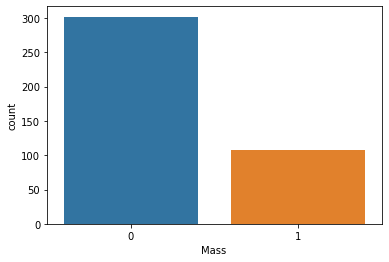

In [164]:
sns.countplot(labels['Mass '])

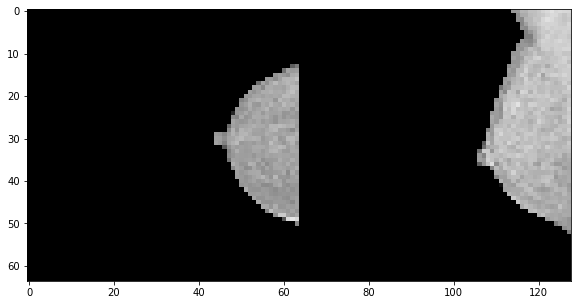

In [165]:
def show_male_and_female():
    female = read_image(train_image_name[0])
    male = read_image(train_image_name[2])
    pair = np.concatenate((female, male), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
show_male_and_female()

In [166]:


train_image_name[0]



'Dataset/22678622'

In [169]:
train_male_image = []
train_female_image = []
for each in train_image_name:
    if each.split('/')[5] in train_male_data['File Name'].values:
        train_male_image.append(each)
    else:train_male_image = []
train_female_image = []
for each in train_image_name:
    if each.split('/')[5] in train_male_data['Filename'].values:
        train_male_image.append(each)
    else:
        train_female_image.append(each)

IndexError: list index out of range

In [170]:
### Creating VGG 16 model for training it on male and female data

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def malefemale():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))



    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = malefemale()

TypeError: ('Keyword argument not understood:', 'border_mode')